In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
# Directories for template audio and clip to make detections in

CLIP_PATH = "data/example/030525_003_20250503_174500.wav"
TEMPLATE_PATH = "data/example/Streptopelia_semitorquata_100465.mp3"

# Customizable parameters for template matching:
# Threshold for detection confidence
# Suppression distance to avoid multiple detections in close proximity

THRESHOLD = 0.6
SUPPRESSION_DISTANCE = 50

In [3]:
# Computes mel spectrogram from an audio signal

def compute_mel_spectrogram(y, sr, n_mels=128, hop_length=512):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

In [4]:
# Converts a mel spectrogram in dB to an image format suitable for use in template matching or visualization

def spectrogram_to_image(S_dB):
    img = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
    img = (img * 255).astype(np.uint8)
    return img

In [5]:
# Load the template audio file and compute the mel spectrogram

y, sr = librosa.load(TEMPLATE_PATH, sr=None)
template_spectrogram = compute_mel_spectrogram(y, sr)
template_db = librosa.amplitude_to_db(np.abs(template_spectrogram), ref=np.max)

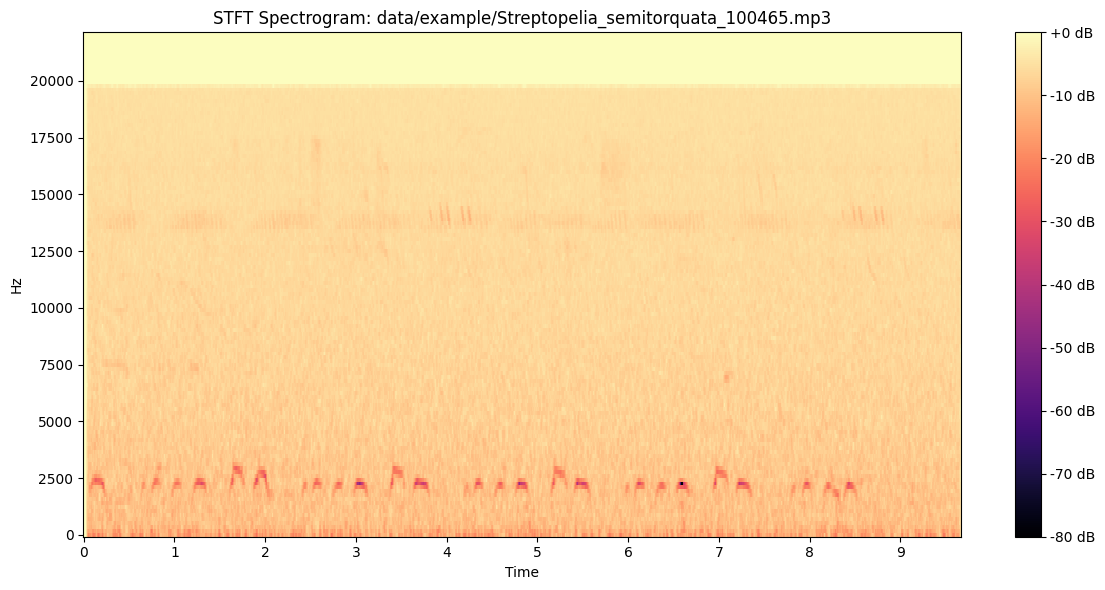

In [6]:
# Display the mel spectrogram of the template audio

plt.figure(figsize=(12, 6))
librosa.display.specshow(template_db, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
plt.colorbar(format="%+2.0f dB")
plt.title(f"STFT Spectrogram: {TEMPLATE_PATH}")
plt.tight_layout()
plt.show()

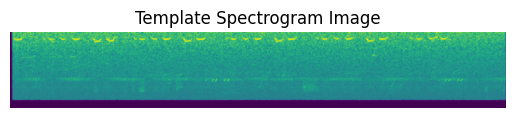

In [7]:
# Display image of clip spectrogram

template_img = spectrogram_to_image(template_spectrogram)

plt.imshow(template_img)
plt.axis('off')
plt.title("Template Spectrogram Image")
plt.show()

In [8]:
# Load the clip audio file and compute its mel spectrogram

y_clip, sr_clip = librosa.load(CLIP_PATH, sr=None)
clip_spec = compute_mel_spectrogram(y_clip, sr_clip)

# Convert the clip spectrogram to an image for template matching

clip_img = spectrogram_to_image(clip_spec)

# Perform template matching using OpenCV, using normalized cross-correlation

res = cv.matchTemplate(clip_img, template_img, cv.TM_CCOEFF_NORMED)

Found 17164 matches above threshold 0.6

Kept 289 non-overlapping matches above threshold 0.6

Match found at 42.67 sec (Score: 0.667)
Match found at 42.40 sec (Score: 0.664)
Match found at 43.06 sec (Score: 0.662)
Match found at 41.69 sec (Score: 0.661)
Match found at 84.40 sec (Score: 0.660)
Match found at 41.38 sec (Score: 0.660)
Match found at 41.96 sec (Score: 0.660)
Match found at 43.46 sec (Score: 0.660)
Match found at 84.98 sec (Score: 0.659)
Match found at 86.33 sec (Score: 0.658)
Match found at 41.11 sec (Score: 0.657)
Match found at 85.75 sec (Score: 0.657)
Match found at 86.04 sec (Score: 0.656)
Match found at 84.12 sec (Score: 0.656)
Match found at 84.67 sec (Score: 0.655)
Match found at 86.66 sec (Score: 0.655)
Match found at 85.25 sec (Score: 0.655)
Match found at 88.03 sec (Score: 0.654)
Match found at 43.80 sec (Score: 0.653)
Match found at 86.94 sec (Score: 0.653)
Match found at 40.81 sec (Score: 0.652)
Match found at 87.76 sec (Score: 0.652)
Match found at 83.85 sec 

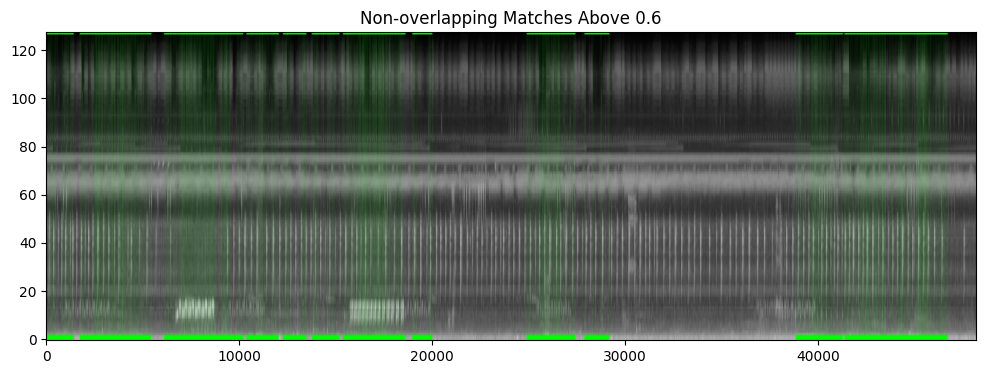

In [9]:
# Find locations where the matching score exceeds the threshold

locations = np.where(res >= THRESHOLD)
matches = []
for pt in zip(*locations[::-1]):
    x, y = pt
    score = res[y, x]
    matches.append((y, x, score))

matches.sort(key=lambda x: x[2], reverse=True)

print(f"Found {len(matches)} matches above threshold {THRESHOLD}\n")

# Suppress overlapping matches based on the defined distance

selected = []
for y, x, score in matches:
    if all(abs(x - xc) > SUPPRESSION_DISTANCE for _, xc, _ in selected):
        selected.append((y, x, score))

print(f"Kept {len(selected)} non-overlapping matches above threshold {THRESHOLD}\n")

# Visualize the matches on the clip spectrogram image

seconds_per_col = 512 / sr_clip

plt.figure(figsize=(12, 4))
vis = cv.cvtColor(clip_img, cv.COLOR_GRAY2BGR)

for y, x, score in selected:
    top_left = (x, y)
    bottom_right = (x + template_img.shape[1], y + template_img.shape[0])
    cv.rectangle(vis, top_left, bottom_right, (0, 255, 0), 2)

    timestamp = x * seconds_per_col
    print(f"Match found at {timestamp:.2f} sec (Score: {score:.3f})")

plt.imshow(vis, aspect='auto', origin='lower', cmap='gray')
plt.title(f"Non-overlapping Matches Above {THRESHOLD}")
plt.show()

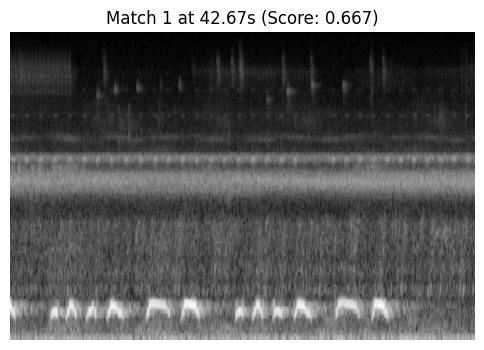

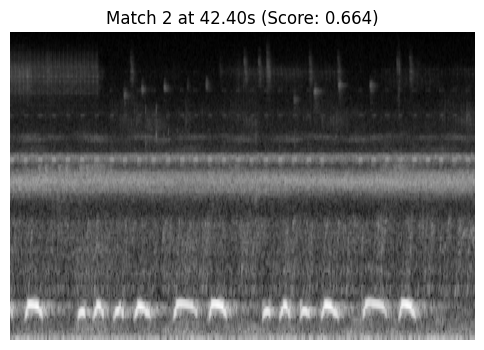

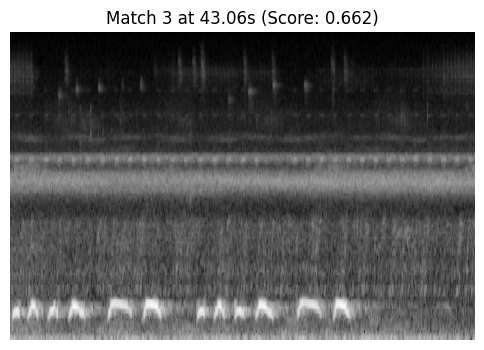

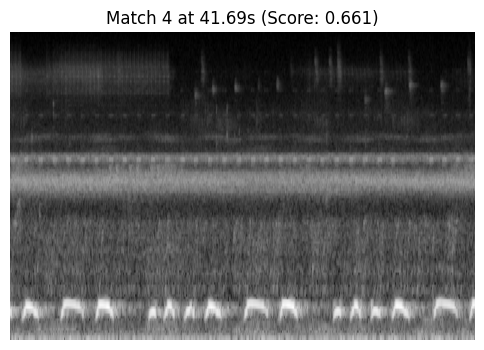

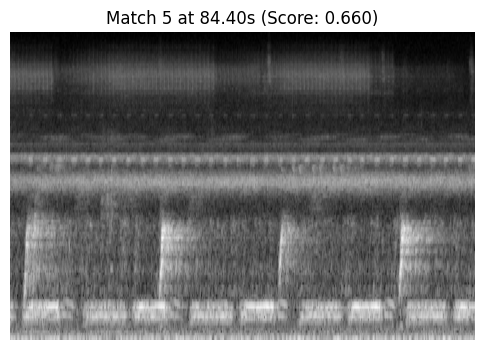

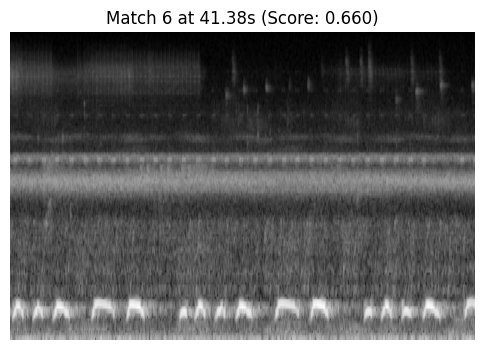

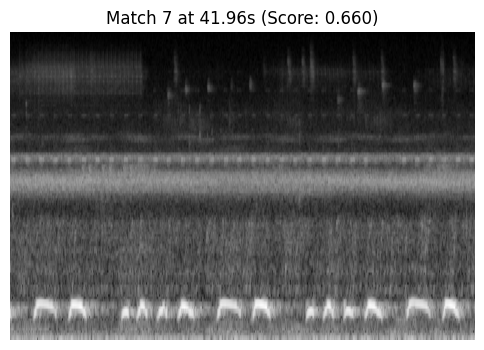

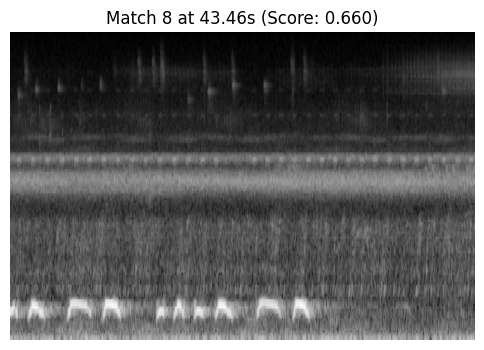

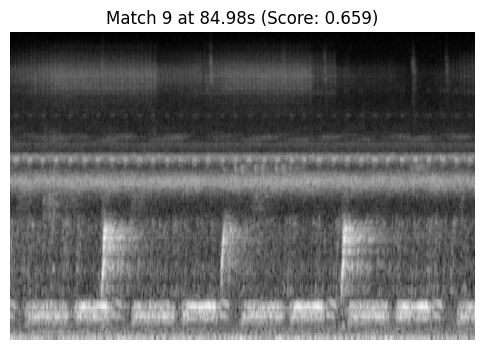

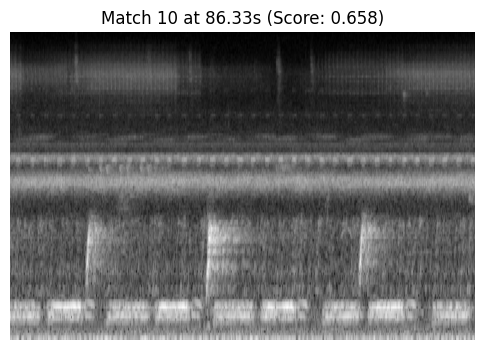

In [10]:
# Customize the number of top matches to display

top_matches = selected[:10]

# Display zoomed in regions around the top matches

margin = 20

for idx, (y, x, score) in enumerate(top_matches, 1):
    x1 = max(0, x - margin)
    x2 = min(clip_img.shape[1], x + template_img.shape[1] + margin)
    y1 = max(0, y - margin)
    y2 = min(clip_img.shape[0], y + template_img.shape[0] + margin)

    zoom_region = clip_img[y1:y2, x1:x2]

    plt.figure(figsize=(6, 4))
    plt.imshow(zoom_region, aspect='auto', origin='lower', cmap='gray')
    timestamp = x * seconds_per_col
    plt.title(f"Match {idx} at {timestamp:.2f}s (Score: {score:.3f})")
    plt.axis('off')
    plt.show()